This notebook will be used for the following analysis:

> Importing articles from Guardian API

> Using spacy for entity recognition, specifically Locations and Organizations mentioned

> Clustering visualisation and topic modelling using word vectors and t-SNE to identify similar articles
>> (Nearest neighbors to generate a list?)


> Create a knowledge graph using the entity recognition, and visualising using igraph

In [53]:
import pandas as pd
from pandas import json_normalize
import en_core_web_sm
from sklearn.manifold import TSNE
import pyLDAvis
import requests
import os
import networkx as nx
%matplotlib inline

# Retrieve environment variables (for API keys, etc.)
from dotenv import load_dotenv
%dotenv # automatically detects the location of the .env file
load_dotenv()

%load_ext autoreload
%autoreload 2
%aimport article_analysis

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### 1. Generate our article dataset via the Guardian's API - [Get yours here](https://open-platform.theguardian.com/access/) 

In [29]:
def search_guardian_articles(search_term, api_key, page=1, page_size=100, format_='json'):
    '''Retrieves meta data of articles matching the search term'''
    search_term = search_term.replace(' ', '%20')
    
    # Now, we'll make the request
    url = 'https://content.guardianapis.com/search'
    params = {'api-key':API_KEY,
             'format':'json',
              'page':page,
              'page-size':page_size,
             'q':search_term}
    response = requests.get(url, params=params)
    return response.json()

In [31]:
API_KEY = os.environ["GUARDIAN_API"]
df = pd.DataFrame()
number_of_records_to_retrieve = 10000
for i in range(1,int(number_of_records_to_retrieve / 100 + 1)):
    try:
        data = json_normalize(search_guardian_articles('real estate', api_key=API_KEY, page=i)['response']['results'])
        df = df.append(data)
    except:
        break

In [33]:
sections_to_keep = ['Science','Society','Politics','Money','News','Culture','Environment','Business','Media','Art and design',
                   'Shelter: supporting those who are struggling','UK news','Technology','Cities','Education','Global development','Law',
                   'Housing Network','Improving lives through business innovation','Community']
df = df[df.sectionName.isin(sections_to_keep)].reset_index(drop=True)

In [34]:
from article_analysis.models import TopicModeller

tm = TopicModeller(df)

tm.generate_word_vector_plot(column='webTitle')

Loading BokehJS ...

In [35]:
tm.topic_count = 10
tm.generate_lda_visualisation(df.webTitle)

In [113]:
from article_analysis.data import TextProcessing

entity_types = ['ORG','PERSON','FAC','GPE','LOC','EVENT','WORK_OF_ART']
title_entities = [ TextProcessing.list_of_entities(x, entity_type=entity_types) for x in df.webTitle ]

In [137]:
df['entities_mentioned'] = [ title_entities[x][0] for x in range(len(title_entities)) ]
df['entities_labels'] = [ title_entities[x][1] for x in range(len(title_entities)) ]

In [61]:
df.head()

,id,type,sectionId,sectionName,webPublicationDate,webTitle,webUrl,apiUrl,isHosted,pillarId,pillarName
0,science/2020/jun/04/metal-detecting-versus-rea...,article,science,Science,2020-06-04T16:52:46Z,Metal-detecting versus real archaeology| Letter,https://www.theguardian.com/science/2020/jun/0...,https://content.guardianapis.com/science/2020/...,False,pillar/news,News
1,society/2020/may/22/clapping-distracts-from-th...,article,society,Society,2020-05-22T16:18:58Z,Clapping distracts from the real issues | Letters,https://www.theguardian.com/society/2020/may/2...,https://content.guardianapis.com/society/2020/...,False,pillar/news,News
2,politics/2020/feb/29/who-is-the-real-priti-patel,article,politics,Politics,2020-02-29T08:00:40Z,Who is the real Priti Patel?,https://www.theguardian.com/politics/2020/feb/...,https://content.guardianapis.com/politics/2020...,False,pillar/news,News
3,society/2020/jun/11/universal-credit-wait-firs...,article,society,Society,2020-06-11T09:38:08Z,Universal credit: wait for first payment a 're...,https://www.theguardian.com/society/2020/jun/1...,https://content.guardianapis.com/society/2020/...,False,pillar/news,News
4,world/2020/may/13/coronavirus-real-care-home-d...,article,society,Society,2020-05-13T09:30:39Z,Coronavirus: real care home death toll double ...,https://www.theguardian.com/world/2020/may/13/...,https://content.guardianapis.com/world/2020/ma...,False,pillar/news,News


In [75]:
from networkx import Graph

titles = [x for x in df.head(100).webTitle ]
sections = [x for x in df.head(100).sectionName ]
nodes = titles + sections
#nodes = list(set(nodes))
edges = list(zip(titles, sections))

g = Graph()

g.add_nodes_from(nodes)
g.add_edges_from(edges)

AttributeError: 'bool' object has no attribute 'items'

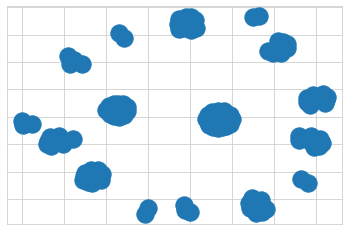

In [78]:
nx.draw_networkx(g, labels=False)